In [1]:
#!pixi add pyarrow autogluon bokeh

In [2]:
# import sys
# !{sys.executable} -m pip install autogluon.eda --quiet

In [3]:
%cd ..

/home/pwd/Codes/hadithi/dev.io


In [4]:
import numpy as np
import pandas as pd

In [5]:
dataf = pd.read_parquet("assets/books/train.parquet")
test = pd.read_parquet("assets/books/test.parquet")

In [6]:
def lower_columns(df):
    df.columns = df.columns.str.lower()

    return df

In [8]:
def get_data(dataf):
    return (
        dataf.loc[dataf["Genre"].str.contains("Books")]
        .assign(
            Genre=lambda d: d["Genre"].str.replace(" (Books)", "", regex=True),
            Ratings=lambda d: d["Ratings"].str.extract("(\d+)").astype(np.int16),
            Reviews=lambda d: d["Reviews"].str.extract("(\d\.\d)").astype(np.float32),
            Kind=lambda d: d["Edition"].str.split(",– ", expand=False).str[0],
            Year=lambda d: pd.to_datetime(
                d["Edition"]
                .str.split(",– ", expand=False)
                .str[1]
                .str.split(",", expand=False)
                .str[-1]
                .str.strip(),
                format="mixed",
                errors="coerce",
            ),
            Special=lambda d: np.where(
                d["Edition"]
                .str.split(",– ", expand=False)
                .str[1]
                .str.split(",", expand=False)
                .str.len()
                > 1,
                d["Edition"]
                .str.split(",– ", expand=False)
                .str[1]
                .str.split(",", expand=False)
                .str[0],
                np.nan,
            ),
        )
        .drop(columns=["Edition"])
        .pipe(lower_columns)
    )


datax = get_data(dataf)

In [9]:
datax

,title,author,reviews,ratings,synopsis,genre,bookcategory,price,kind,year,special
0,The Prisoner's Gold (The Hunters 3),Chris Kuzneski,4.0,8,THE HUNTERS return in their third brilliant no...,Action & Adventure (Books),Action & Adventure,220.00,Paperback,NaT,NaN
1,Guru Dutt: A Tragedy in Three Acts,Arun Khopkar,3.9,14,A layered portrait of a troubled genius for wh...,Cinema & Broadcast (Books),"Biographies, Diaries & True Accounts",202.93,Paperback,NaT,NaN
3,A Pocket Full of Rye (Miss Marple),Agatha Christie,4.1,13,A handful of grain is found in the pocket of a...,Contemporary Fiction (Books),"Crime, Thriller & Mystery",180.00,Paperback,NaT,NaN
5,ChiRunning: A Revolutionary Approach to Effort...,Danny Dreyer,4.5,8,The revised edition of the bestselling ChiRunn...,Healthy Living & Wellness (Books),Sports,900.00,Paperback,NaT,NaN
6,Death on the Nile (Poirot),Agatha Christie,4.4,72,Agatha Christie’s most exotic murder mystery\n...,"Crime, Thriller & Mystery (Books)","Crime, Thriller & Mystery",224.00,Paperback,NaT,NaN
...,...,...,...,...,...,...,...,...,...,...,...
6232,Humans: A Brief History of How We F*cked It Al...,Tom Phillips,5.0,2,'F*cking brilliant' Sarah Knight\n'Very funny'...,Anthropology (Books),Humour,322.00,Paperback,NaT,NaN
6233,The Chemist,Stephenie Meyer,3.3,9,"In this gripping page-turner, an ex-agent on t...",Contemporary Fiction (Books),"Crime, Thriller & Mystery",421.00,Paperback,NaT,NaN
6234,The Duke And I: Number 1 in series (Bridgerton...,Julia Quinn,3.8,3,'The most refreshing and radiant love story yo...,Romance (Books),Romance,399.00,Paperback,NaT,NaN
6235,Frostfire (Kanin Chronicles),Amanda Hocking,3.5,4,Frostfire by Amanda Hocking is the stunning fi...,Action & Adventure (Books),Action & Adventure,319.00,Paperback,NaT,NaN


In [10]:
test_index = datax.sample(frac=0.2, random_state=42).index

In [11]:
train_data = datax[~datax.index.isin(test_index)]
test_data = datax[datax.index.isin(test_index)]

In [12]:
from autogluon.eda import auto
from autogluon.multimodal import MultiModalPredictor

In [13]:
target_col = "price"

## Target variable analysis

,count,mean,std,min,25%,50%,75%,max,dtypes,unique,missing_count,missing_ratio,raw_type,special_types
price,4022,512.959781,640.711506,28.0,239.0,352.36,543.0,14100.0,float64,1203,,,float,


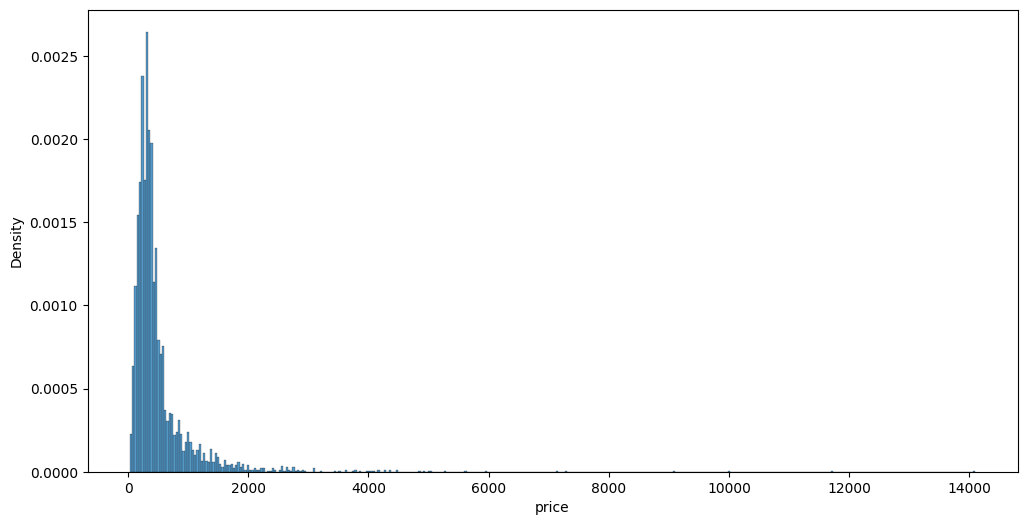

### Distribution fits for target variable
 - ⚠️ none of the [attempted](https://docs.scipy.org/doc/scipy/reference/stats.html#continuous-distributions) distribution fits satisfy specified minimum p-value threshold: `0.01`

### Target variable correlations
 - ⚠️ no fields with absolute correlation greater than `0.5` found for target variable `price`.

In [14]:
auto.target_analysis(
    train_data=train_data,
    label=target_col,
)

### Model Prediction for price

Using validation data for `Test` points

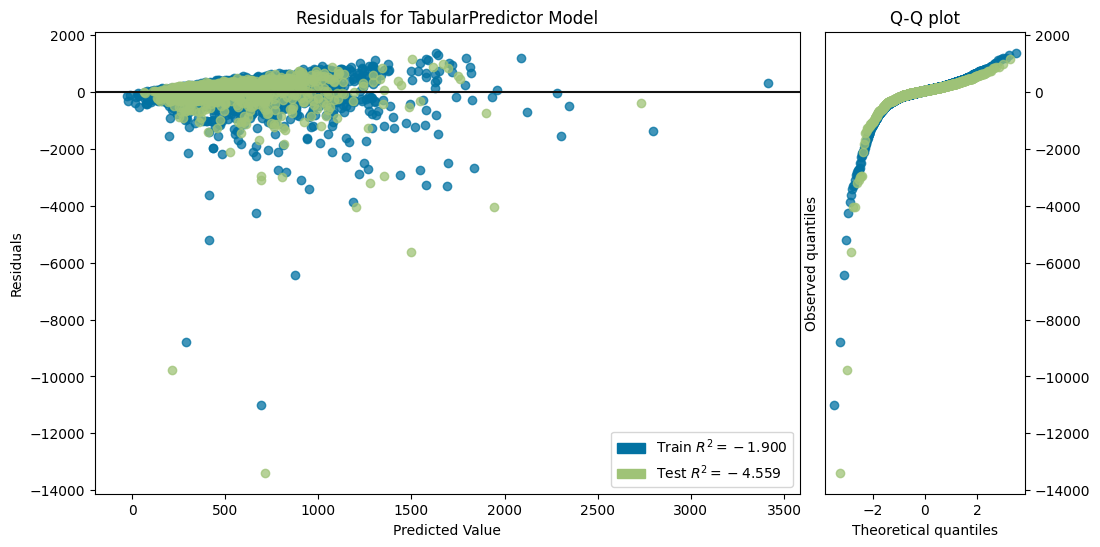

### Model Leaderboard

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,LightGBMXT_BAG_L1,-643.943631,-529.218826,0.097056,0.079744,3.851066,0.097056,0.079744,3.851066,1,True,1


### Feature Importance for Trained Model

,importance,stddev,p_value,n,p99_high,p99_low
synopsis,44.515549,2.344088,9.192345e-07,5,49.342060,39.689039
kind,20.415525,3.760714,1.321364e-04,5,28.158888,12.672162
title,9.995339,1.813697,1.245720e-04,5,13.729766,6.260912
bookcategory,8.835327,1.126960,3.108581e-05,5,11.155753,6.514901
genre,5.451464,1.683222,9.647415e-04,5,8.917241,1.985687
reviews,2.267860,0.631268,6.516098e-04,5,3.567650,0.968069
ratings,1.316297,0.565246,3.242105e-03,5,2.480147,0.152447
special,0.388644,0.317718,2.608022e-02,5,1.042830,-0.265541
author,0.000000,0.000000,5.000000e-01,5,0.000000,0.000000


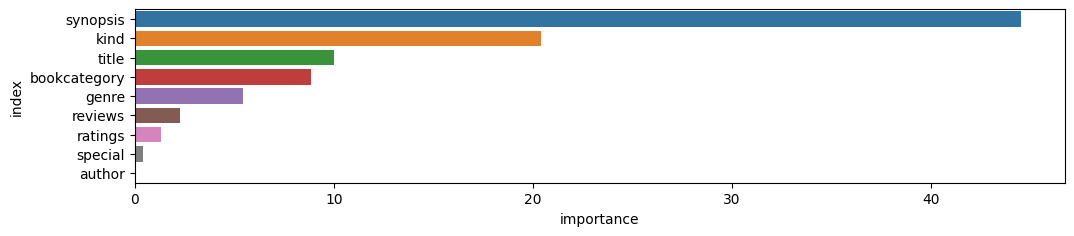

### Rows with the highest prediction error

Rows in this category worth inspecting for the causes of the error

,title,author,reviews,ratings,synopsis,genre,bookcategory,kind,year,special,price,price_pred,error
2455,The Complete Asterix Box Set (36 Titles),Rene Goscinny,4.9,22,"Composed of thirty six, four-colour albums in ...",Comics & Graphic Novels (Books),Comics & Mangas,Product Bundle,NaT,NaN,14100.00,711.915039,13388.084961
2818,On the Night of the Seventh Moon: The Classic ...,Victoria Holt,5.0,1,"For generations, Victoria Holt has dazzled and...",Romance (Books),Romance,Paperback,NaT,NaN,9984.00,214.855515,9769.144485
4463,Essentials of Strength Training and Conditioning,"G.Gregory Haff, N. Travis Triplett",4.5,2,Essentials of Strength Training and Conditioni...,Healthy Living & Wellness (Books),Sports,Hardcover,NaT,NaN,7132.00,1495.759644,5636.240356
3764,Discovering Statistics Using R,Andy Field,3.9,2,Lecturers - request an e-inspection copy of th...,Software & Business Applications (Books),"Computing, Internet & Digital Media",Paperback,NaT,NaN,5253.00,1200.775391,4052.224609
3633,The Tintin Collection: The Adventure of Tintin...,Hergé,4.0,52,Adventures of Tintin have been lauded by both ...,Comics & Mangas (Books),"Arts, Film & Photography",Hardcover,NaT,NaN,5968.00,1942.287598,4025.712402
5567,OCA / OCP Java SE 8 Programmer Certification K...,Jeanne Boyarsky,3.0,2,Your complete certification guide on the path ...,Programming Languages (Books),"Computing, Internet & Digital Media",Paperback,NaT,NaN,4455.00,1275.655884,3179.344116
27,The Buddha Box Set,Osamu Tezuka,4.3,34,The classic eight volume graphic novel series ...,Comics & Graphic Novels (Books),Comics & Mangas,Paperback,NaT,Box set,3779.00,693.700256,3085.299744
708,Coming Back To Me: The Autobiography of Marcus...,Marcus Trescothick,5.0,3,A true-life sporting memoir of one of the best...,Biographies & Autobiographies (Books),Sports,Hardcover,NaT,NaN,3776.55,804.160339,2972.389661
2006,Longman Dictionary of Contemporary English New...,Pearson Education Limited,4.6,52,The Longman Dictionary of Contempory English (...,Language Learning & Teaching (Books),"Language, Linguistics & Writing",Paperback,NaT,NaN,3647.00,689.718506,2957.281494
935,ABAP Development for SAP HANA,"Thorsten Schneider, et al.",4.5,5,See how SAP HANA has changed ABAP! Whether you...,Networks & System Administration (Books),"Computing, Internet & Digital Media",Hardcover,NaT,NaN,4292.00,1354.005371,2937.994629


In [15]:
state = auto.quick_fit(
    train_data,
    target_col,
    path="models/eda",
    return_state=True,
    fit_bagging_folds=3,
    show_feature_importance_barplots=True,
)

,title,author,reviews,ratings,synopsis,genre,bookcategory,kind,year,special,price,price_pred,error
2455,The Complete Asterix Box Set (36 Titles),Rene Goscinny,4.9,22,"Composed of thirty six, four-colour albums in ...",Comics & Graphic Novels (Books),Comics & Mangas,Product Bundle,NaT,NaN,14100.0,711.915039,13388.084961


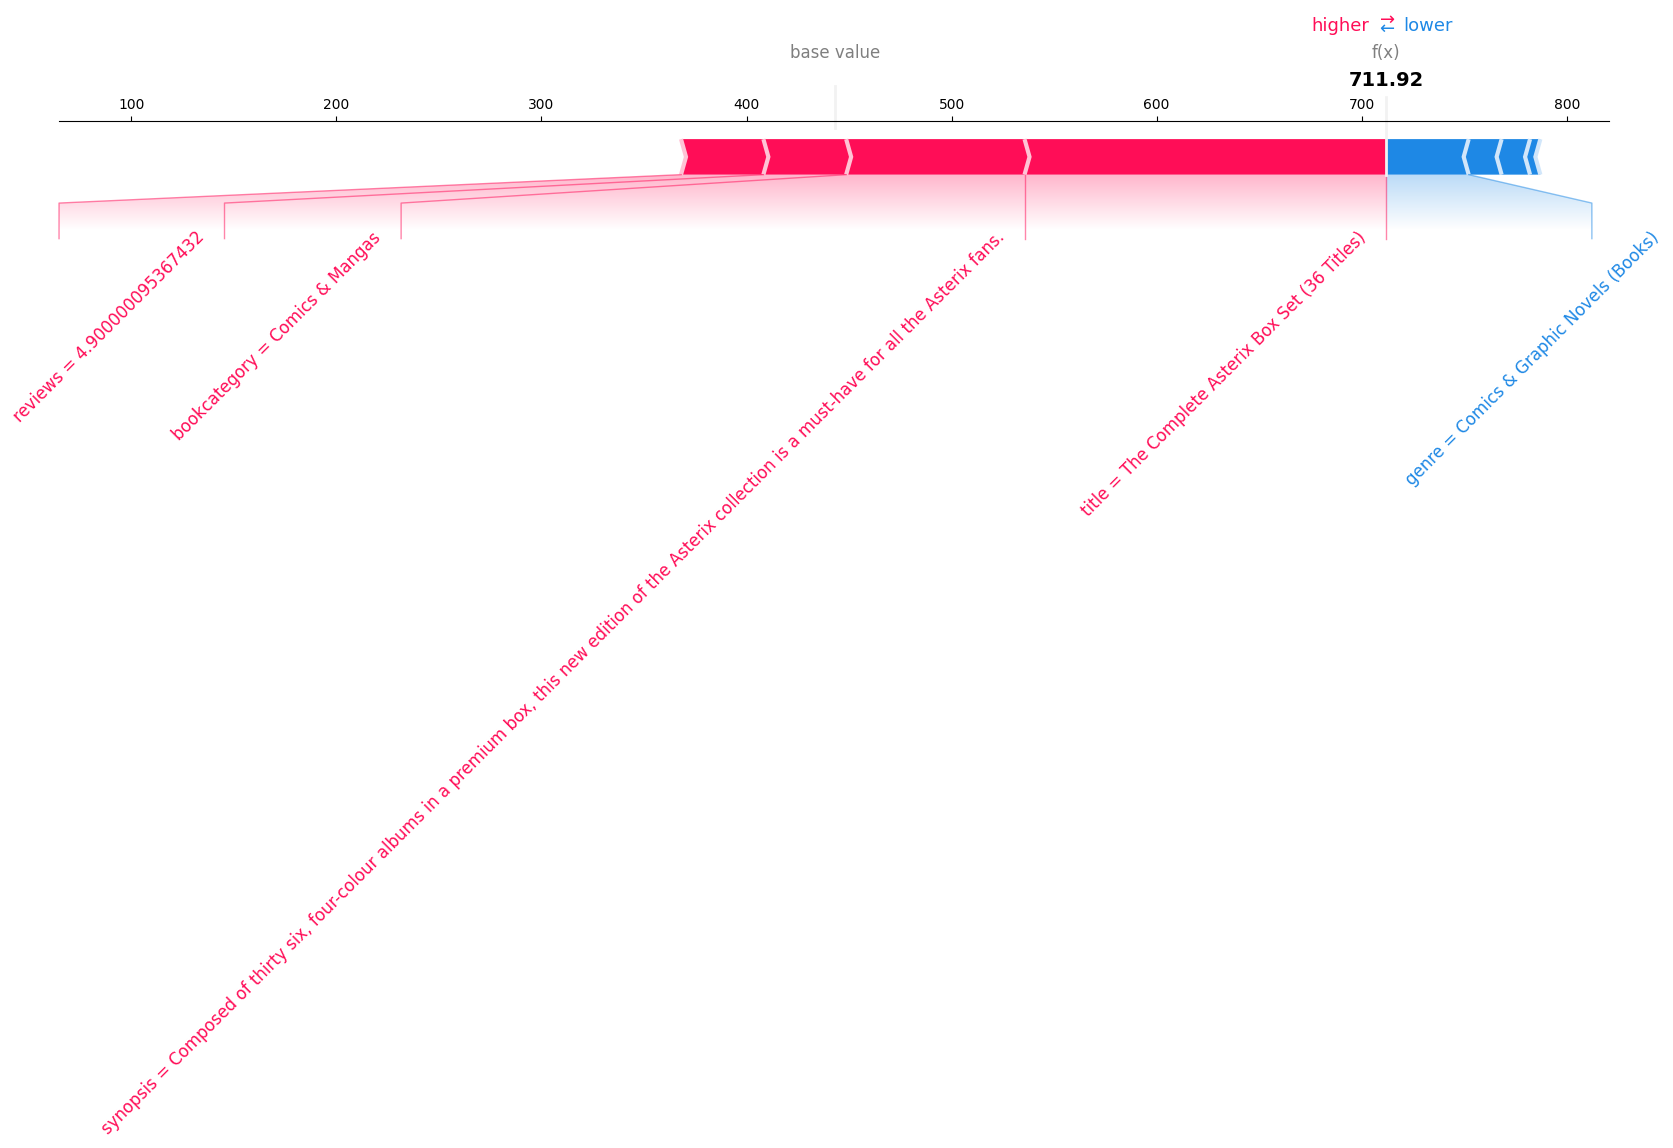

In [16]:
auto.explain_rows(
    train_data=train_data,
    model=state.model,
    display_rows=True,
    rows=state.model_evaluation.highest_error[:1],
)

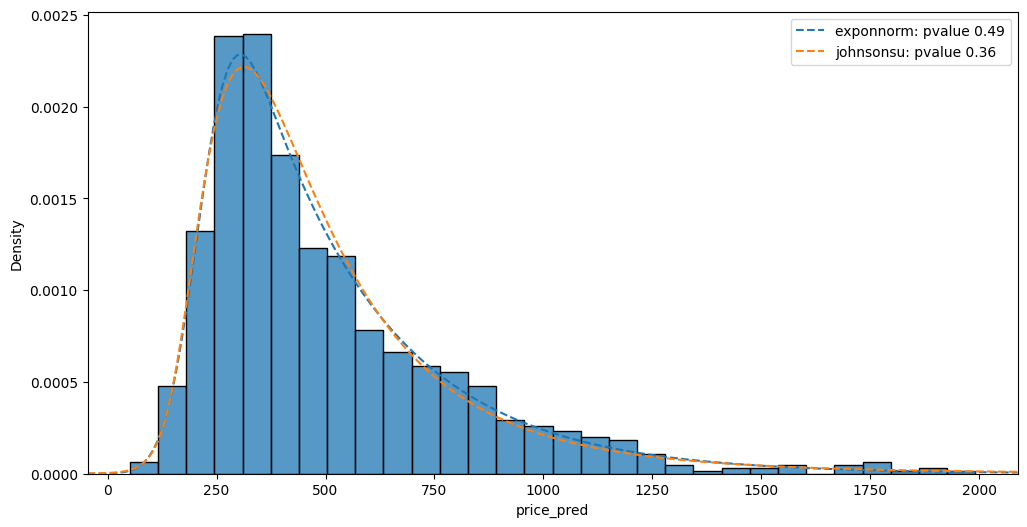

In [17]:
model = state.model
y_pred = model.predict(test_data.drop(columns="price"))
auto.analyze_interaction(
    train_data=pd.DataFrame({"price_pred": y_pred}),
    x="price_pred",
    fit_distributions=["johnsonsu", "norm", "exponnorm"],
)

In [18]:
pd.DataFrame(
    {"price_pred": y_pred.astype(np.float64).round(2), "price": test_data["price"]}
)

,price_pred,price
12,346.36,379.00
18,136.23,291.00
26,285.39,286.98
28,1153.72,802.00
33,372.74,225.00
...,...,...
6214,217.86,249.00
6216,189.15,245.00
6223,542.97,59.00
6227,656.07,2729.00


In [19]:
import warnings

In [ ]:
%%time
with warnings.catch_warnings():
    warnings.simplefilter(action="ignore", category=FutureWarning)

    predictor = MultiModalPredictor(
        label="price",
        problem_type="regression",
        path="models/main",
        # groups="genre",
    ).fit(train_data)

Global seed set to 0
AutoMM starts to create your model. ✨

- AutoGluon version is 0.8.2.

- Pytorch version is 2.0.0.post102.

- Model will be saved to "/home/pwd/Codes/hadithi/dev.io/models/main".

- Validation metric is "rmse".

- To track the learning progress, you can open a terminal and launch Tensorboard:
    ```shell
    # Assume you have installed tensorboard
    tensorboard --logdir /home/pwd/Codes/hadithi/dev.io/models/main
    ```

Enjoy your coffee, and let AutoMM do the job ☕☕☕ Learn more at https://auto.gluon.ai

0 GPUs are detected, and 0 GPUs will be used.

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type                | Params
----------------------------------------------------------
0 | model             | MultimodalFusionMLP | 109 M 
1 | validation_metric | MeanSquaredError    | 0     
2 | loss_func         | MSELoss             | 0     


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

In [31]:
warnings.simplefilter(action="ignore", category=FutureWarning)

predictor.evaluate(test_data, silent=True)

{'root_mean_squared_error': -423.00053327432636,
 'mean_squared_error': -178929.45115036448,
 'mean_absolute_error': -221.38513164027307,
 'r2': 0.4154017982569834,
 'pearsonr': 0.6470321821840215,
 'median_absolute_error': -121.07115173339844}

In [32]:
predictor.leaderboard(data=test_data, silent=True)

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,-423.000533,-527.522156,0.303944,0.145696,132.224245,0.002506,0.000292,0.171645,2,True,12
1,XGBoost,-434.834072,-538.061259,0.080130,0.027489,10.676487,0.080130,0.027489,10.676487,1,True,9
2,LightGBM,-436.007377,-551.617133,0.040628,0.020137,2.009267,0.040628,0.020137,2.009267,1,True,4
3,LightGBMXT,-444.232279,-555.003437,0.043809,0.023482,2.929951,0.043809,0.023482,2.929951,1,True,3
4,ExtraTreesMSE,-466.219167,-554.011040,0.109030,0.061618,131.291309,0.109030,0.061618,131.291309,1,True,7
5,LightGBMLarge,-466.953592,-558.933837,0.032314,0.020386,4.175992,0.032314,0.020386,4.175992,1,True,11
6,NeuralNetFastAI,-469.140349,-549.389412,0.022934,0.011693,3.449889,0.022934,0.011693,3.449889,1,True,8
7,RandomForestMSE,-470.826788,-556.704296,0.113936,0.062603,112.987007,0.113936,0.062603,112.987007,1,True,5
8,NeuralNetTorch,-474.050263,-561.981925,0.026761,0.021555,4.663702,0.026761,0.021555,4.663702,1,True,10
9,CatBoost,-484.879453,-575.993522,0.224018,0.124814,5.467673,0.224018,0.124814,5.467673,1,True,6


In [29]:
predictor.fit_summary(verbosity=2, show_plot=True)

*** Summary of fit() ***
Estimated performance of each model:
                  model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0   WeightedEnsemble_L2 -527.522156       0.145696  132.224245                0.000292           0.171645            2       True         12
1               XGBoost -538.061259       0.027489   10.676487                0.027489          10.676487            1       True          9
2       NeuralNetFastAI -549.389412       0.011693    3.449889                0.011693           3.449889            1       True          8
3              LightGBM -551.617133       0.020137    2.009267                0.020137           2.009267            1       True          4
4         ExtraTreesMSE -554.011040       0.061618  131.291309                0.061618         131.291309            1       True          7
5            LightGBMXT -555.003437       0.023482    2.929951                0.023482      

{'model_types': {'KNeighborsUnif': 'KNNModel',
  'KNeighborsDist': 'KNNModel',
  'LightGBMXT': 'LGBModel',
  'LightGBM': 'LGBModel',
  'RandomForestMSE': 'RFModel',
  'CatBoost': 'CatBoostModel',
  'ExtraTreesMSE': 'XTModel',
  'NeuralNetFastAI': 'NNFastAiTabularModel',
  'XGBoost': 'XGBoostModel',
  'NeuralNetTorch': 'TabularNeuralNetTorchModel',
  'LightGBMLarge': 'LGBModel',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif': -647.9560628921569,
  'KNeighborsDist': -666.1778110214084,
  'LightGBMXT': -555.003437322962,
  'LightGBM': -551.61713324257,
  'RandomForestMSE': -556.7042956120737,
  'CatBoost': -575.9935217665359,
  'ExtraTreesMSE': -554.0110398202335,
  'NeuralNetFastAI': -549.3894115209727,
  'XGBoost': -538.0612592670092,
  'NeuralNetTorch': -561.981925323205,
  'LightGBMLarge': -558.9338366268403,
  'WeightedEnsemble_L2': -527.5221564631099},
 'model_best': 'WeightedEnsemble_L2',
 'model_paths': {'KNeighborsUnif': ['KNeighborsUni

In [38]:
predicted_price = (
    predictor.predict(test_data.drop(columns=["price"])).astype(np.float64).round(2)
)
predicted_price

12      312.92
18      361.24
26      339.77
28      801.40
33      376.81
         ...  
6214    324.68
6216    294.79
6223    358.91
6227    857.96
6233    302.45
Name: price, Length: 1006, dtype: float64